Run a group analysis using FSL.  The data are obtained from the Human Connectome Project, and include 32 subjects on a relational matching task (using the Relational - Match contrast).

In [4]:
import os
from nipype.interfaces import fsl
import nibabel
import numpy
import nilearn.plotting

%matplotlib inline

import matplotlib.pyplot as plt

basedir='/Users/poldrack/data_unsynced/HCP/HCP_relational'
analysis_dir=os.path.join(basedir,'group_cope4')
copefile=os.path.join(basedir,'cope.nii.gz')
varcopefile=os.path.join(basedir,'varcope.nii.gz')
nsubs=32


First run using OLS.

In [21]:
if not os.path.exists(analysis_dir):
    os.mkdir(analysis_dir)
    
deshdr="""/NumWaves	1
/NumPoints	32
/PPheights		1.000000e+00

/Matrix"""

conhdr="""/ContrastName1	group mean
/NumWaves	1
/NumContrasts	1
/PPheights		1.000000e+00
/RequiredEffect		1.441

/Matrix"""

grouphdr="""/NumWaves	1
/NumPoints	32

/Matrix"""
os.chdir(analysis_dir)
desmtx=numpy.ones((nsubs,1))
numpy.savetxt('design.mat',desmtx,fmt='%1.0f',header=deshdr,comments='')
numpy.savetxt('covsplit.txt',desmtx,fmt='%1.0f',header=grouphdr,comments='')
conmtx=numpy.ones(1)
numpy.savetxt('design.con',conmtx,fmt='%1.0f',header=conhdr,comments='')

flameo = fsl.FLAMEO(cope_file=copefile, 
                    var_cope_file=varcopefile,
                    design_file='design.mat',
                    cov_split_file='covsplit.txt',
                    t_con_file='design.con',
                    mask_file=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz'),
                    run_mode='ols')
flameo.run()

try:
    os.rename('stats','stats_OLS')
except:
    if not os.path.exists('stats_OLS'):
        print 'hmm, something went terribly wrong'

INFO:interface:stdout 2015-07-15T14:26:30.016173:Log directory is: stats
INFO:interface:stdout 2015-07-15T14:26:30.017315:Setting up:
INFO:interface:stdout 2015-07-15T14:26:32.203824:ntptsing=32.000000 
INFO:interface:stdout 2015-07-15T14:26:32.203824:
INFO:interface:stdout 2015-07-15T14:26:32.203824:evs_group=1.000000 
INFO:interface:stdout 2015-07-15T14:26:32.203824:
INFO:interface:stdout 2015-07-15T14:26:32.205564:No f contrasts
INFO:interface:stdout 2015-07-15T14:26:32.459417:
INFO:interface:stdout 2015-07-15T14:26:32.459417:WARNING: The passed in varcope file, /Users/poldrack/data_unsynced/HCP/HCP_relational/varcope.nii.gz, contains voxels inside the mask with zero (or negative) values. These voxels will be excluded from the analysis.
INFO:interface:stdout 2015-07-15T14:26:32.482387:nevs=1
INFO:interface:stdout 2015-07-15T14:26:32.486885:ntpts=32
INFO:interface:stdout 2015-07-15T14:26:32.487964:ngs=1
INFO:interface:stdout 2015-07-15T14:26:32.490062:nvoxels=196706
INFO:interface:st

Estimate smoothness and compute cluster-corrected thresholded map

In [22]:
est = fsl.SmoothEstimate()
est.inputs.dof=32
est.inputs.residual_fit_file = 'stats_OLS/res4d.nii.gz'
est.inputs.mask_file = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz')
smoothness=est.run()

INFO:interface:stdout 2015-07-15T14:48:51.474466:DLH 0.218496
INFO:interface:stdout 2015-07-15T14:48:51.474466:VOLUME 196706
INFO:interface:stdout 2015-07-15T14:48:51.474466:RESELS 21.4018


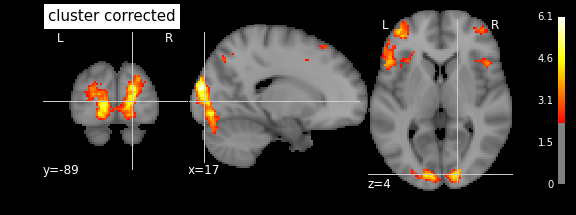

In [35]:
cl = fsl.Cluster()
cl.inputs.threshold = 2.3
cl.inputs.in_file = 'stats_OLS/zstat1.nii.gz'
cl.inputs.terminal_output = 'file' 
cl.inputs.dlh=smoothness.outputs.dlh
cl.inputs.volume=smoothness.outputs.volume
cl.inputs.pthreshold=0.05
cl.inputs.out_threshold_file='stats_OLS/zstat1_thresh.nii.gz'
cl.run()

os.rename('stdout.nipype','stats_OLS/zstat1_cluster_max.txt')

thresh_zstat_OLS=nibabel.load('stats_OLS/zstat1_thresh.nii.gz')
bgimage=nibabel.load(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'))
map_display=nilearn.plotting.plot_stat_map(thresh_zstat_OLS,bgimage,threshold=2.3,title='cluster corrected')

Run same model using mixed effects with FLAME 1

In [40]:
flameo = fsl.FLAMEO(cope_file=copefile, 
                    var_cope_file=varcopefile,
                    design_file='design.mat',
                    cov_split_file='covsplit.txt',
                    t_con_file='design.con',
                    mask_file=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz'),
                    run_mode='flame1')
flameo.run()

try:
    os.rename('stats','stats_FLAME1')
except:
    if not os.path.exists('stats_FLAME1'):
        print 'hmm, something went terribly wrong'


INFO:interface:stdout 2015-07-15T15:14:32.680004:Log directory is: stats
INFO:interface:stdout 2015-07-15T15:14:32.684134:Setting up:
INFO:interface:stdout 2015-07-15T15:14:34.945273:ntptsing=32.000000 
INFO:interface:stdout 2015-07-15T15:14:34.945273:
INFO:interface:stdout 2015-07-15T15:14:34.945273:evs_group=1.000000 
INFO:interface:stdout 2015-07-15T15:14:34.945273:
INFO:interface:stdout 2015-07-15T15:14:34.947929:No f contrasts
INFO:interface:stdout 2015-07-15T15:14:35.175952:
INFO:interface:stdout 2015-07-15T15:14:35.175952:WARNING: The passed in varcope file, /Users/poldrack/data_unsynced/HCP/HCP_relational/varcope.nii.gz, contains voxels inside the mask with zero (or negative) values. These voxels will be excluded from the analysis.
INFO:interface:stdout 2015-07-15T15:14:35.186521:nevs=1
INFO:interface:stdout 2015-07-15T15:14:35.186521:ntpts=32
INFO:interface:stdout 2015-07-15T15:14:35.186521:ngs=1
INFO:interface:stdout 2015-07-15T15:14:35.186521:nvoxels=196706
INFO:interface:st

Run fixed effects model for comparison

In [42]:
flameo = fsl.FLAMEO(cope_file=copefile, 
                    var_cope_file=varcopefile,
                    design_file='design.mat',
                    cov_split_file='covsplit.txt',
                    t_con_file='design.con',
                    mask_file=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz'),
                    run_mode='fe')
flameo.run()

try:
    os.rename('stats','stats_fe')
except:
    if not os.path.exists('stats_fe'):
        print 'hmm, something went terribly wrong'


INFO:interface:stdout 2015-07-15T15:18:06.828116:Log directory is: stats
INFO:interface:stdout 2015-07-15T15:18:06.830056:Setting up:
INFO:interface:stdout 2015-07-15T15:18:08.973039:ntptsing=32.000000 
INFO:interface:stdout 2015-07-15T15:18:08.973039:
INFO:interface:stdout 2015-07-15T15:18:08.973039:evs_group=1.000000 
INFO:interface:stdout 2015-07-15T15:18:08.973039:
INFO:interface:stdout 2015-07-15T15:18:08.975100:No f contrasts
INFO:interface:stdout 2015-07-15T15:18:09.211596:
INFO:interface:stdout 2015-07-15T15:18:09.211596:WARNING: The passed in varcope file, /Users/poldrack/data_unsynced/HCP/HCP_relational/varcope.nii.gz, contains voxels inside the mask with zero (or negative) values. These voxels will be excluded from the analysis.
INFO:interface:stdout 2015-07-15T15:18:09.222486:nevs=1
INFO:interface:stdout 2015-07-15T15:18:09.224131:ntpts=32
INFO:interface:stdout 2015-07-15T15:18:09.224131:ngs=1
INFO:interface:stdout 2015-07-15T15:18:09.224131:nvoxels=196706
INFO:interface:st

Plot fixed effects stats against OLS and OLS against FLAME1

mean absolute difference:
FE Z - OLS Z: 0.882653
OLS Z - FLAME1 Z: 0.29869


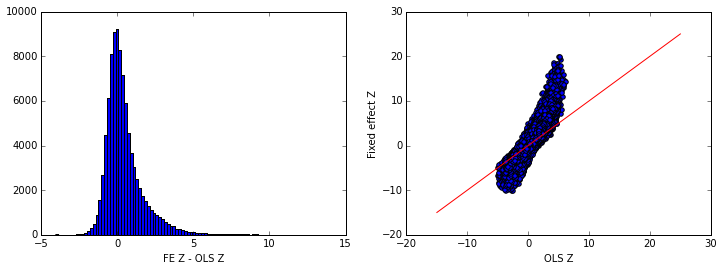

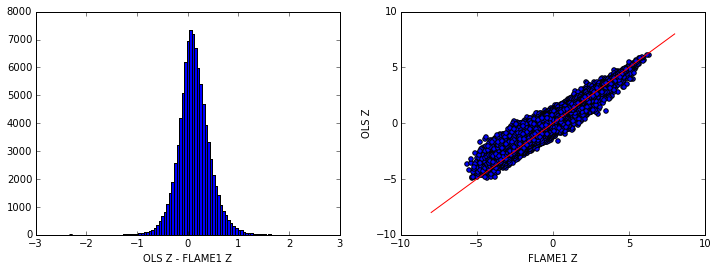

In [102]:
try:
    maskdata
except:
    zstat_fe=nibabel.load('stats_fe/zstat1.nii.gz').get_data()
    zstat_FLAME1=nibabel.load('stats_FLAME1/zstat1.nii.gz').get_data()
    zstat_OLS=nibabel.load('stats_OLS/zstat1.nii.gz').get_data()
    maskdata=(zstat_fe!=0)*(zstat_FLAME1!=0)*(zstat_OLS!=0)

mindata=numpy.min([numpy.min(zstat_fe[maskdata>0]),numpy.min(zstat_OLS[maskdata>0])])
maxdata=numpy.max([numpy.max(zstat_fe[maskdata>0]),numpy.max(zstat_OLS[maskdata>0])])
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(zstat_fe[zstat_OLS>0] - zstat_OLS[zstat_OLS>0],100)
plt.xlabel('FE Z - OLS Z')
plt.subplot(122)

sc=plt.scatter(zstat_OLS[maskdata>0],zstat_fe[maskdata>0])
mindata=numpy.min([sc.get_axes().get_xlim()[0],sc.get_axes().get_ylim()[0]])
maxdata=numpy.max([sc.get_axes().get_xlim()[1],sc.get_axes().get_ylim()[1]])
plt.plot([mindata,maxdata],[mindata,maxdata],color='red')
plt.ylabel('Fixed effect Z')
plt.xlabel('OLS Z')


mindata=numpy.min([numpy.min(zstat_FLAME1[maskdata>0]),numpy.min(zstat_OLS[maskdata>0])])
maxdata=numpy.max([numpy.max(zstat_FLAME1[maskdata>0]),numpy.max(zstat_OLS[maskdata>0])])
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(zstat_OLS[zstat_OLS>0] - zstat_FLAME1[zstat_OLS>0],100)
plt.xlabel('OLS Z - FLAME1 Z')
plt.subplot(122)

sc=plt.scatter(zstat_FLAME1[maskdata>0],zstat_OLS[maskdata>0])
mindata=numpy.min([sc.get_axes().get_xlim()[0],sc.get_axes().get_ylim()[0]])
maxdata=numpy.max([sc.get_axes().get_xlim()[1],sc.get_axes().get_ylim()[1]])
plt.plot([mindata,maxdata],[mindata,maxdata],color='red')
plt.ylabel('OLS Z')
plt.xlabel('FLAME1 Z')

print 'mean absolute difference:'
print 'FE Z - OLS Z:',numpy.mean(numpy.abs(zstat_fe[maskdata>0] - zstat_OLS[maskdata>0]))
print 'OLS Z - FLAME1 Z:',numpy.mean(numpy.abs(zstat_OLS[maskdata>0] - zstat_FLAME1[maskdata>0]))

Look for outlier subjects by examining residuals

In [105]:
residfile='stats_FLAME1/res4d.nii.gz'
res4d=nibabel.load(residfile).get_data()
resdata=numpy.zeros((res4d.shape[3],numpy.sum(maskdata)))

for i in range(res4d.shape[3]):
    tmp=res4d[:,:,:,i]
    resdata[i,:]=tmp[maskdata>0]

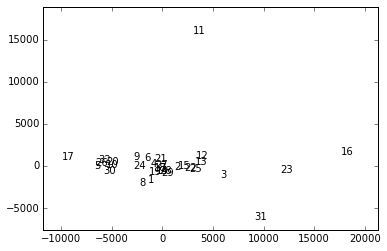

In [126]:
import sklearn.manifold
t=sklearn.manifold.TSNE(init='pca')
embedding=t.fit_transform(resdata)
plt.figure()
plt.axis([numpy.min(embedding[:,0])*1.2,numpy.max(embedding[:,0])*1.2,numpy.min(embedding[:,1])*1.2,numpy.max(embedding[:,1])*1.2])
for i in range(embedding.shape[0]):
    
    plt.text(embedding[i,0],embedding[i,1],'%d'%int(i+1))


In [ ]:
import sklearn.cluster
hclust=sklearn.cluster()
